In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from matplotlib import pylab as plt
from scipy import stats

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Medium questions

In [7]:
mu = stats.norm(0, 1)
mu_samples = mu.rvs(10000)

sigma = stats.expon(1)
sigma_samples = sigma.rvs(10000)

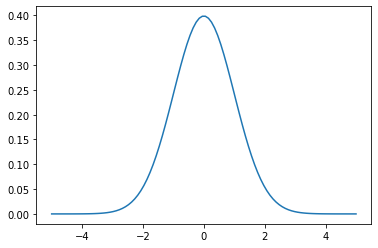

In [3]:
plt.plot(np.linspace(-5, 5, 100), mu.pdf(np.linspace(-5, 5, 100)))

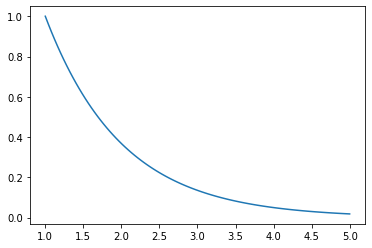

In [4]:
plt.plot(np.linspace(1, 5, 100), sigma.pdf(np.linspace(1, 5, 100)))

In [8]:
y = stats.norm(mu_samples,sigma_samples)

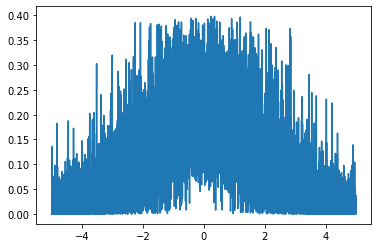

In [12]:
plt.plot(np.linspace(-5, 5, 10000), y.pdf(np.linspace(-5, 5, 10000)))

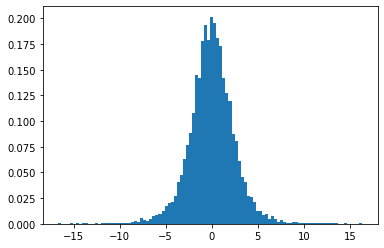

In [15]:
plt.hist(y.rvs(10000), bins=100, density=True);

### 4.4

A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical
model definition for this regression, using any variable names and priors you choose. Be prepared to
defend your choice of priors.

In [36]:
sigma = stats.expon(1)
a = stats.lognorm(110) #intercept starting with 110 cm
b = stats.lognorm(0,1) # lognormal distribution coefficient of height with values beetwen (0,1)
# below data not from the book but created by my imagination
x = np.round(np.linspace(160,190,100),2) # height of the student in first year of school
xx = np.round(np.linspace(163,195,100),2) # height of the student in first year of school
xxx = np.round(np.linspace(167,200,100),2) # height of the student in first year of school

mu = a + b * x + xx * b + xxx*b # linear model of height of the student
y = stats.norm(mu,sigma) # final bayes reggresion model

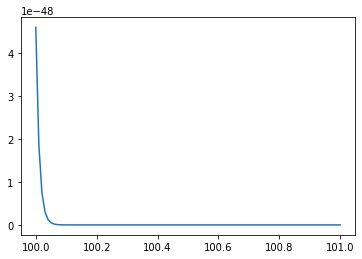

In [79]:
plt.plot(np.linspace(100,101,100),stats.expon(1).pdf(np.linspace(110,200,100)))

### 4.7

Refit model m4.3 from the chapter, but omit the mean weight xbar this time. Compare the
new model’s posterior to that of the original model. In particular, look at the covariance among the
parameters. What is different? Then compare the posterior predictions of both models.

In [80]:
howell1 = pd.read_csv("E:/Python/Statistical rethinking/statisitcal-rethinking/Rethinking_2/Data/Howell1.csv", delimiter=";")
data = howell1[howell1.age >= 18]

In [81]:
with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * data.weight.values 
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data.height.values)
    mean_q = pm.find_MAP()
    print(mean_q)
    # find the hessian matrix
    Hess = pm.find_hessian(mean_q, vars=[a, b, sigma])
    trace_4_3 = pm.sample(1000, tune=1000)


{'a': array(114.53429928), 'b_log__': array(-0.11571354), 'sigma_interval__': array(-2.18116924), 'b': array(0.89073034), 'sigma': array(5.07271445)}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1462 seconds.
The acceptance probability does not match the target. It is 0.7082, but should be close to 0.8. Try to increase the number of tuning steps.


In [82]:
az.summary(trace_4_3, var_names=["a", "b", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,114.503,1.851,110.903,117.849,0.050,0.036,1349.0,1439.0,1.0
b,0.891,0.041,0.818,0.970,0.001,0.001,1362.0,1375.0,1.0
sigma,5.106,0.193,4.761,5.482,0.005,0.003,1785.0,1537.0,1.0


In [83]:
trace_4_3_df = trace_4_3.posterior.to_dataframe()
trace_4_3_df.cov().round(3)

,a,b,sigma
a,3.426,-0.075,-0.009
b,-0.075,0.002,0.000
sigma,-0.009,0.000,0.037


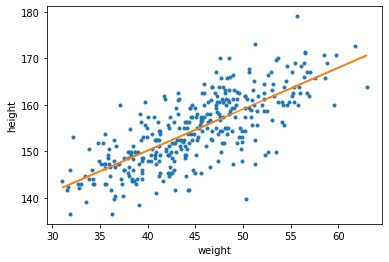

In [85]:
plt.plot(data.weight, data.height, ".")
plt.plot(
    data.weight,
    trace_4_3.posterior["a"].mean().item(0)
    + trace_4_3.posterior["b"].mean().item(0) * data.weight ,
)
plt.xlabel(data.columns[1])
plt.ylabel(data.columns[0]);

In [88]:
np.mean(data.weight) * 0.9 + mean_q["a"]

155.0257362456614

In [90]:
var_cov = np.linalg.inv(Hess)

In [92]:
stats.norm.interval(0.89, loc=mean_q["b"], scale=np.sqrt(var_cov[1, 1]))

(0.8158060707963478, 0.9656546183484628)

In [93]:
stats.norm.interval(0.89, loc=mean_q["a"], scale=np.sqrt(var_cov[1, 1]))

(114.4593750039876, 114.60922355153973)

In [94]:
stats.norm.interval(0.89, loc=mean_q["sigma"], scale=np.sqrt(var_cov[1, 1]))

(4.997790177097344, 5.147638724649458)

In [101]:
means = np.fromiter(mean_q.values(), dtype=float)[[0, 3, 4]]
# resample for posterior for 10,000 sample
post_samples = np.random.multivariate_normal(means, var_cov, size=10000)
# compute the hpdi for a range of weight values
cred_intervals = np.array(
    [az.hdi(post_samples[:, 0] + post_samples[:, 1] * (x)) for x in np.linspace(30, 70)]
)

In [104]:
cred_intervals.size

100

In [106]:
# compute the prediction interval in one line
pred_intervals = np.array(
    [
        az.hdi(np.random.normal(loc=post_samples[:, 0] + post_samples[:, 1] * (x), scale=post_samples[:, 2]))
        for x in np.linspace(30, 70)
    ]
)

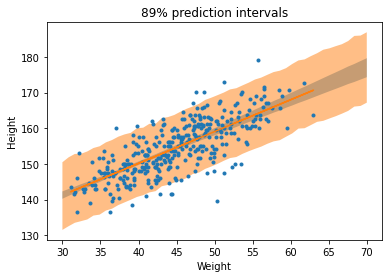

In [107]:
plt.plot(data.weight, data.height, ".")
plt.plot(
    data.weight,
    trace_4_3.posterior["a"].mean().item(0)
    + trace_4_3.posterior["b"].mean().item(0) * data.weight ,
)
plt.fill_between(np.linspace(30,70), cred_intervals[:,0], cred_intervals[:,1], alpha=0.5)
plt.fill_between(np.linspace(30,70), pred_intervals[:,0], pred_intervals[:,1], alpha=0.5)

plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("89% prediction intervals");

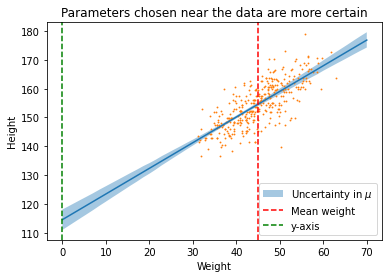

In [109]:
mu = mean_q["a"] + mean_q["b"] * (np.linspace(0, 70, 100))
cred_intervals = np.array(
    [az.hdi(post_samples[:, 0] + post_samples[:, 1] * (x)) for x in np.linspace(0, 70)]
)
plt.fill_between(
    np.linspace(0, 70),
    cred_intervals[:, 0],
    cred_intervals[:, 1],
    alpha=0.4,
    label=r"Uncertainty in $\mu$",
)
plt.plot(np.linspace(0, 70, 100), mu)
plt.scatter(data.weight, data.height, s=0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.axvline(np.mean(data.weight), ls="--", c="r", label="Mean weight")
plt.axvline(0, ls="--", c="g", label="y-axis")
plt.title("Parameters chosen near the data are more certain")
plt.legend();